In [1]:
import numpy as np
#import os

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from astropy.io import fits

from setup import *
from FullFrame import FullFrame

##--------------------------------------------------------------------------##
##             NECESSARY USER INPUTS BELOW....                              ##
##--------------------------------------------------------------------------##

##################
###   WASP4b   ###
##################
#obs_date='ut20150819'                           #observation date
#obj_name='Wasp4'                                #object name   
#midtime=['2015-08-19T07:43:00.00']                 #time of midtransit, WAsp-4b

###################
###   WASP52b   ###
###################
obs_date='ut20160811'
#obs_date='ut20160922'
obj_name='Wasp52'

midtime=['2016-08-11T04:51:00']               #time of midtransit, Wasp-52b, Transit1
#midtime=['2016-09-22T04:44:00']               #time of midtransit, Wasp-52b, Transit2

##################
###   Hats8b   ###
##################
#obs_date='ut20170723'                           #observation date
#obs_date='ut20170828'
#obj_name='Hats8'                                #object name  

#midtime=['2017-07-24T05:28:01.056']                 #time of midtransit, Hats-8b, Transit 1
#midtime=['2017-08-29T01:36:04.608']                 #time of midtransit, Hats-8b Transit 2


path='/Volumes/ermay_ext/Magellan/'+obs_date+'/'
data_path=path+obj_name+'_Spec/'      #path to where your data is saved
flat_path=path+obj_name+'_Flats/'     #path to where your SLIT flats are saved
DARKS=path+obj_name+'_Darks/'     #path to where your darks are saved
FLATS=path+'Full_Flats/'             #path to where the full field flats are saved 
WAVE=path+obj_name+'_Arcs/'

#SAVEPATH='SaveData/'+obj_name+'/'
SAVEPATH=path+'SaveData_'+obj_name+'/'

wavelength_path=path+'WaveSolution/'



extray=400 #number of extra pixels to extract per side in y direction
extrax=80  #number on the side to find wavelength strip, only for nights with a single mask


binn=1    #binning
#### CHECK BINNING IN SETUP.PY ####
#### if 1x1 binning, xpixels,ypixels should be 2048,4096
#### if 2x2 binning, xpixels,ypixels should be 1024,2048
print xpixels/binn, ypixels/binn

2048 4096


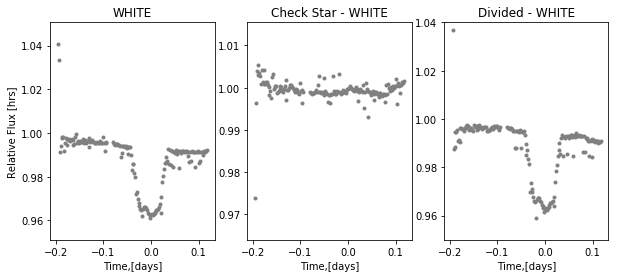

[ 4600.  4800.  5000.  5200.  5400.  5600.  5800.  6000.  6200.  6400.
  6600.  6800.  7000.  7200.  7400.  7600.  7800.  8000.  7800.]


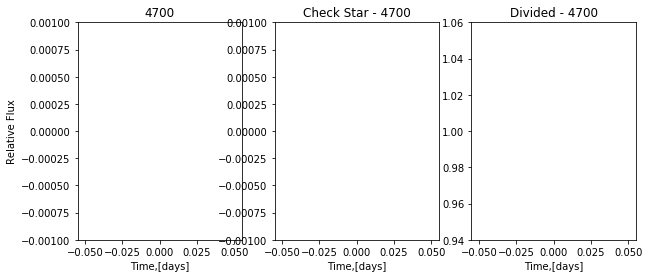

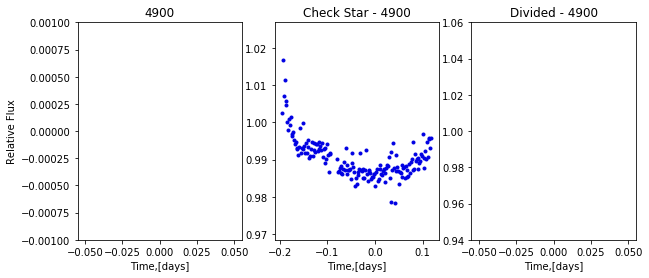

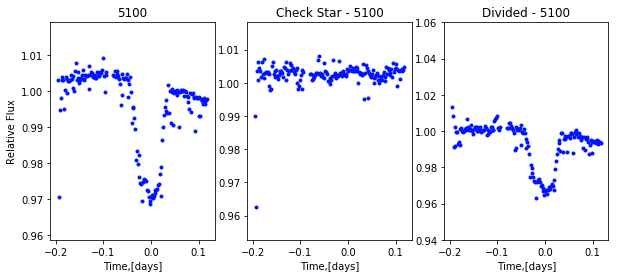

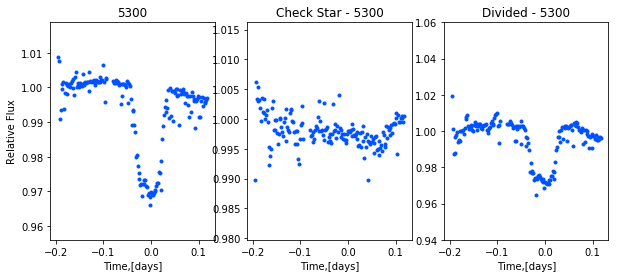

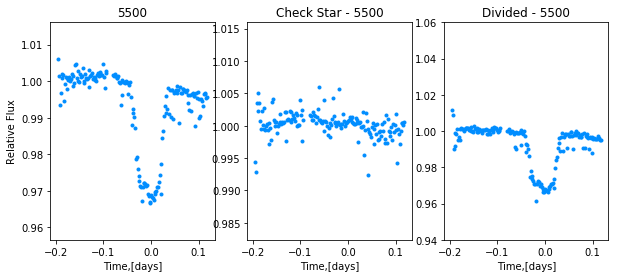

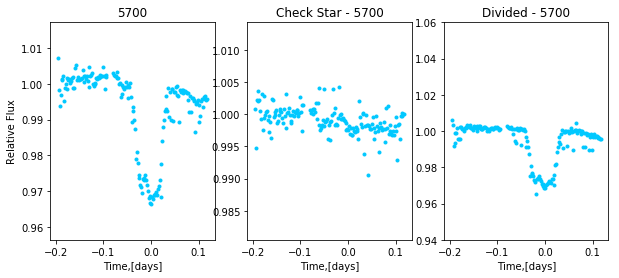

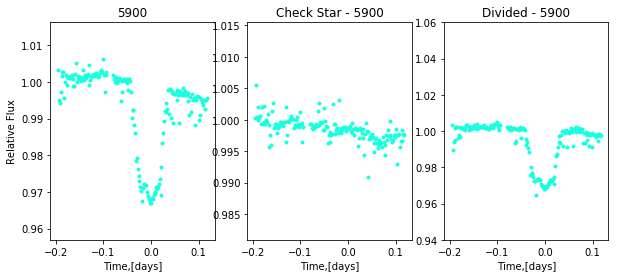

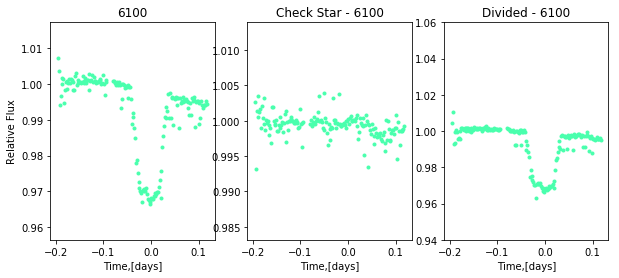

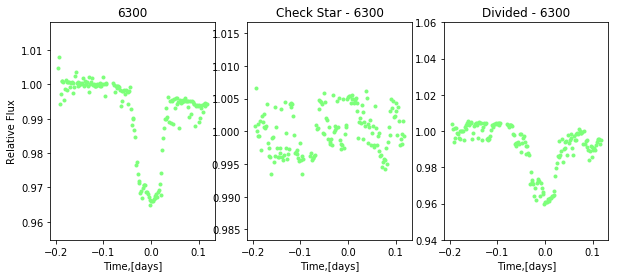

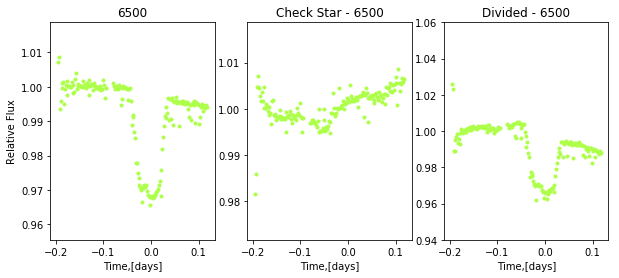

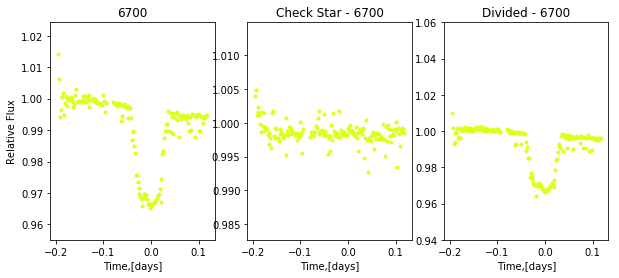

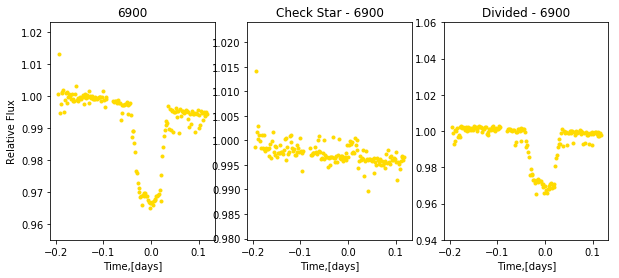

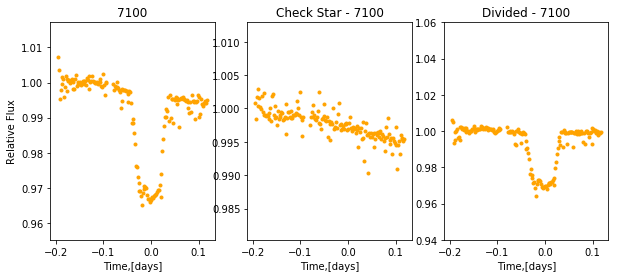

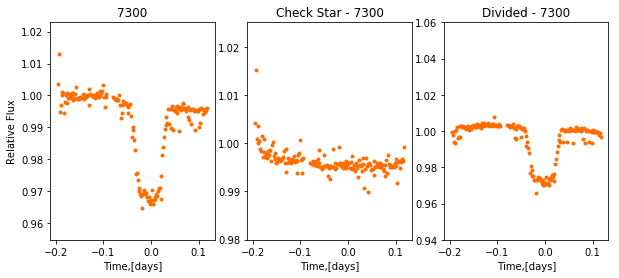

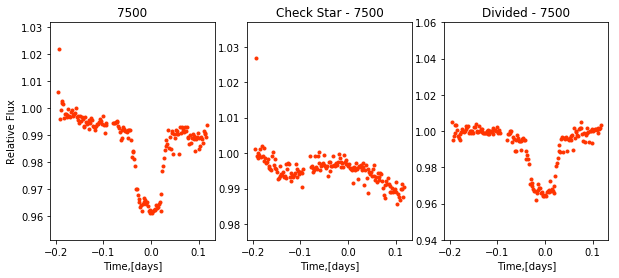

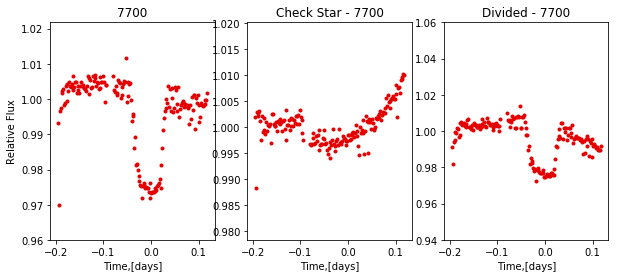

In [15]:
from GenerateLC import LCgen_binns,LCgen_white


corr=True
width=200

Cals_ind=[2,3,5,8]
csn=2

white=LCgen_white(SAVEPATH,corr,Cals_ind,csn)
binns=LCgen_binns(SAVEPATH,width,corr,Cals_ind,csn)

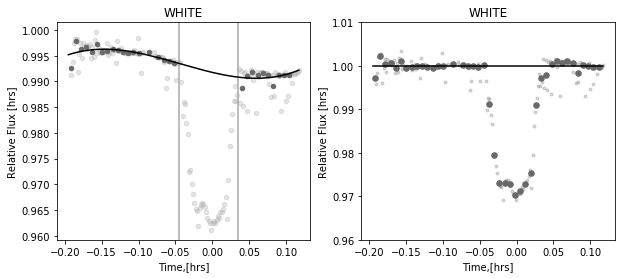

[ 4600.  4800.  5000.  5200.  5400.  5600.  5800.  6000.  6200.  6400.
  6600.  6800.  7000.  7200.  7400.  7600.  7800.  8000.  7800.]


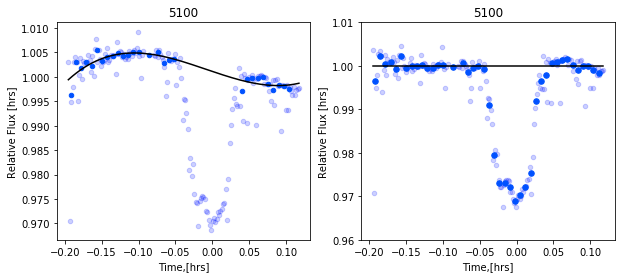

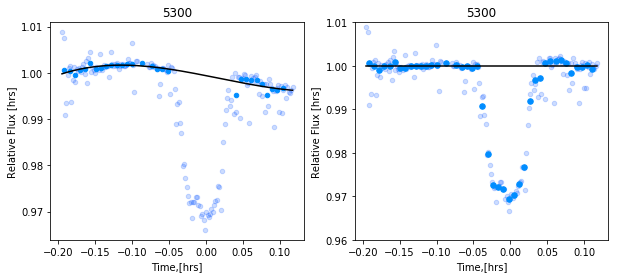

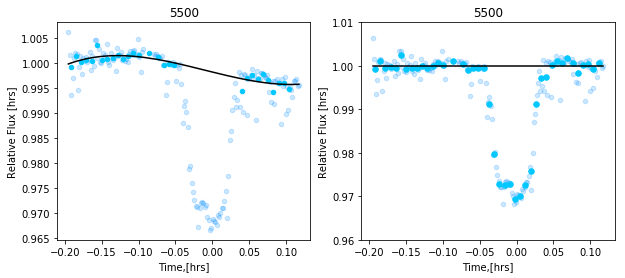

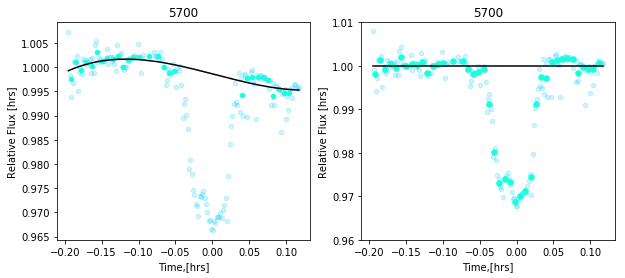

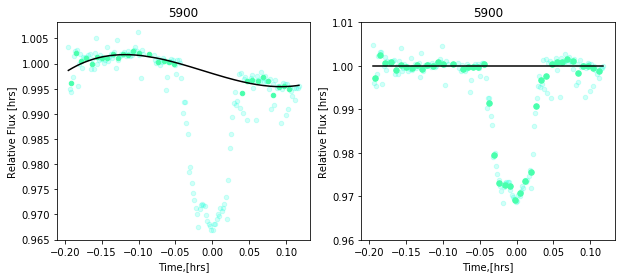

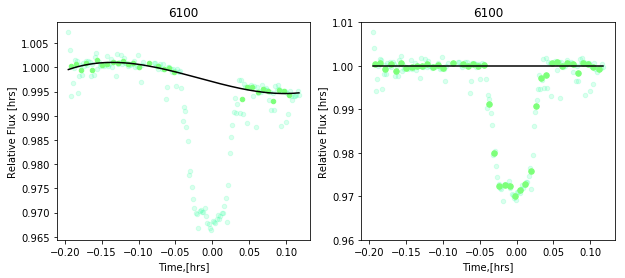

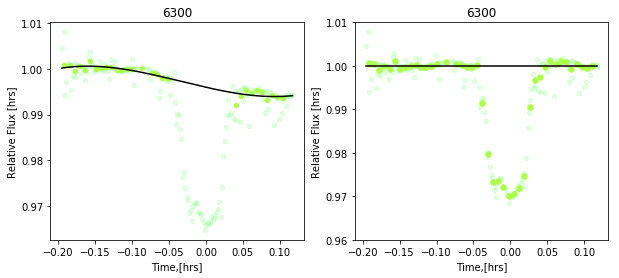

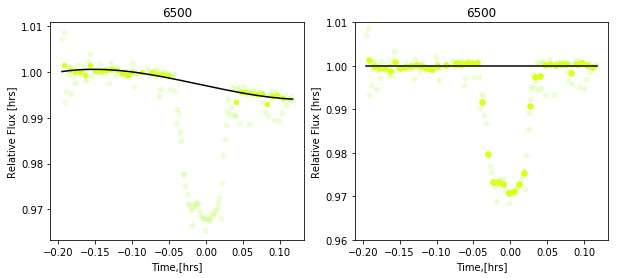

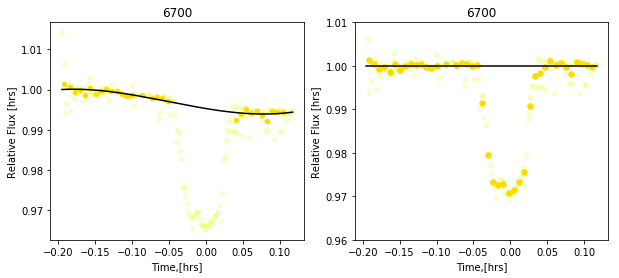

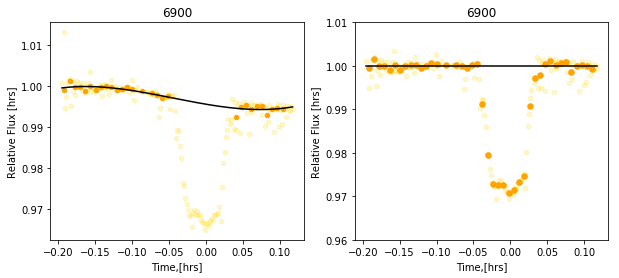

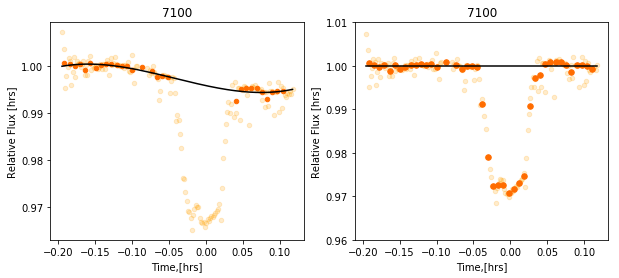

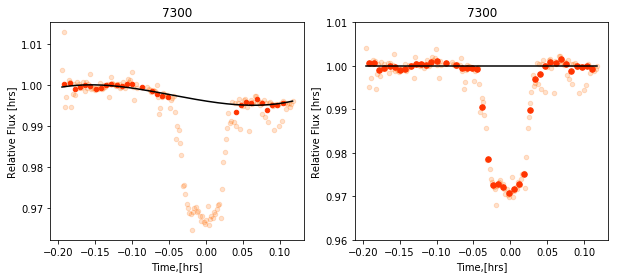

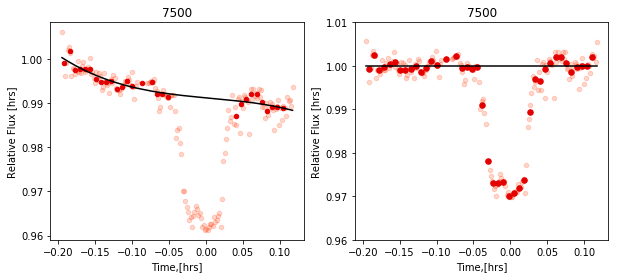

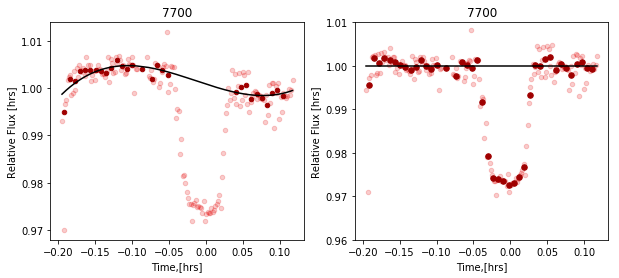

In [16]:
#Hats8 transit 1--- -0.05, 0.06
#W52 transit 1 --- -0.045, 0.035
#W52 transit 2 -- 
from BaselineFitting import blfit_binns,blfit_white

order=3         # polynomial order (in time)
avg=4           # number of points to average together
olow=0.94       # outlier - low end
ohigh=1.02      # outlier - high end
ybot=0.96       # ylim - low end (plot)
ytop=1.01       # ylim - high end (plot)

timein=-0.045
timeeg=0.035

#corr=False
#width=200


white=blfit_white(SAVEPATH,order,avg,olow,ohigh,ybot,ytop,timein,timeeg,corr)
binns=blfit_binns(SAVEPATH,width,order,avg,olow,ohigh,ybot,ytop,timein,timeeg,corr)

In [2]:
#from LCfit import lcfit

width=50
corr=False
avg=False
nwalkers=500
burnin=500
nsteps=5000
#color=0   #0=white, 1=bins

#white=lcfit(SAVEPATH,width,corr,avg,nwalkers,burnin,nsteps,0)
#binns=lcfit(SAVEPATH,width,corr,avg,nwalkers,burnin,nsteps,1)

In [3]:
#####################################################                                                                                           
#####################################################                                                                                           
##        Fitting of lightcurves using BATMAN      ##                                                                                           
##  ---------------------------------------------  ##                                                                                           
##  reads in .npz files from Lightcurve_Script.py  ##                                                                                           
##     See README.txt in Magellan/pipeline         ##                                                                                           
#####################################################                                                                                           
#####################################################   

import numpy as np
np.seterr(all='ignore')

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import batman

import emcee
import corner

#import astropy
#from astropy.time import Time
#import pyfits                                                                                                                                  

import scipy
from scipy.interpolate import interp1d

from datetime import datetime
startTime1=datetime.now()

import sys
print (sys.argv)
 

sys.path.insert(0,SAVEPATH) 
from SystemCons import *

#width=200


#################################
t=np.load(SAVEPATH+'Obs_times.npz')['times']
n_exp=len(t)

if corr==True:
    if avg==True:
        lc_data_white=np.load(SAVEPATH+'LCwhite_br_Corr.npz')['avf']
        lc_data_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'_Corr.npz')['avf']
        yerr_white=np.load(SAVEPATH+'LCwhite_br_Corr.npz')['err_t']
        yerr_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'_Corr.npz')['err_t']
    else:
        lc_data_white=np.load(SAVEPATH+'LCwhite_br_Corr.npz')['data']
        lc_data_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'_Corr.npz')['data']
        yerr_white=np.load(SAVEPATH+'LCwhite_br_Corr.npz')['err_t']
        yerr_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'_Corr.npz')['err_t']
else:
    if avg==True:
        lc_data_white=np.load(SAVEPATH+'LCwhite_br.npz')['avf']
        lc_data_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['avf']
        yerr_white=np.load(SAVEPATH+'LCwhite_br.npz')['err_t']
        yerr_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['err_t']
    else:   
        lc_data_white=np.load(SAVEPATH+'LCwhite_br.npz')['data']
        lc_data_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['data']
        yerr_white=np.load(SAVEPATH+'LCwhite_br.npz')['err_t']
        yerr_binns=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['err_t']
    
bin_ctr=np.load(SAVEPATH+'LC_bins_br_'+str(int(width))+'.npz')['bin_ctr']

####################################################                                                                                            
norm=matplotlib.colors.Normalize(vmin=np.min(bin_ctr),vmax=np.max(bin_ctr))                                                                                                                 
colors=matplotlib.cm.Spectral_r
scal_m=matplotlib.cm.ScalarMappable(cmap=colors,norm=norm)
scal_m.set_array([])

####################################################                                                                                            
#              LIMB DARKENING FUNCION              #                                                                                            
####################################################                                                                                            
# U B V R I J H K                                                                                                                               

limb_dark='quadratic'

wave=[3640,4450,5510,6580,8060,12200]#,16300,21900]                                                                                             

q0_func=interp1d(wave,q0)
q1_func=interp1d(wave,q1)

####################################################                                                                                            
#              LIGHT CURVE FUNCTION                #                                                                                            
####################################################                                                                                            
def lc_func(t,t0,per,rp,a,inc,ecc,w,u,limb_dark):
    params=batman.TransitParams()
    params.t0=t0
    params.per=per
    params.rp=rp
    params.a=a
    params.inc=inc
    params.ecc=ecc
    params.w=w
    params.u=u
    params.limb_dark=limb_dark

    model=batman.TransitModel(params,t)
    return params, model

####################################################                                                                                            
#     Prior, Likelihood, Posterior Functions       #                                                                                            
####################################################                                                                                            
def loggaus(mean,sig,param):
    return -np.log(np.sqrt(2*np.pi*sig**2.))-((param-mean)**2.)/(2*sig**2.)

def lnprior(theta,color):
    if color==0:
        t0_f,per_f,rp_f,inc_f,c1_f,c2_f=theta
        if t0_f>t0dn and t0_f<t0up and rp_f>rpdn and rp_f<rpup and np.abs(c2_f-c2)<0.1 and np.abs((c2_f-c2)-(c1_f-c1))<0.05:
            return loggaus(per,per_e,per_f)+loggaus(inc,inc_e,inc_f)
        else:
            return -np.inf
    if color==1:
        rp_f,c1_f,c2_f=theta
        if rp_f<rpup and rp_f>rpdn and np.abs(c2_f-c2)<0.1 and np.abs((c2_f-c2)-(c1_f-c1))<0.05:
            return 0.0
        else:
            return -np.inf

def lnlike(theta,params,model,t,flux,err,color):
    if color==0:
        params.t0,params.per,params.rp,params.inc,c1_f,c2_f=theta
        params.u=[c1_f,c2_f]
        Ms_s=np.random.normal(loc=Ms,scale=Ms_e)
        Rs_s=np.random.normal(loc=Rs,scale=Rs_e)
        smacm=(((params.per*24.*60.*60.)**2.*Grav*Ms_s)/(4*np.pi**2.))**(1./3.)
        params.a=smacm/Rs_s
        fit=model.light_curve(params)
        residuals=flux-fit
        return -0.5*(np.nansum((residuals/err)**2))
    if color==1:
        params.rp,c1_f,c2_f=theta
        params.u=[c1_f,c2_f]
        fit=model.light_curve(params)
        residuals=flux-fit
        return -0.5*(np.nansum((residuals/err)**2))


def lnprob(theta,params,model,t,flux,err,color):
    prior=lnprior(theta,color)
    if not np.isfinite(prior):
        return -np.inf
    post=prior+lnlike(theta,params,model,t,flux,err,color)
    return post

####################################################                                                                                            
#     RUN MCMC CODE      #                                                                                            
####################################################   

def runmcmc(nwalkers,burnin,nsteps,pos0,params,model,time,data,error,color):
    sampler=emcee.EnsembleSampler(nwalkers,ndim,lnprob,a=2.0, args=(params,m,t,data,error,color))
    
    Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
    Output.write('{0} \n'.format('     -->> Running Burn-in...'))
                                                                                                                        
    time1=datetime.now()
    p0,test1,test2=sampler.run_mcmc(pos0,burnin)
    time2=datetime.now()
    Output.write('{0} {1} \n'.format('           Time to Run: ', time2-time1))
    sampler.reset()
                                                                                                                          

    Output.write('{0} \n'.format('     -->> Running Chain...'))
    Output.close()
    for i, result in enumerate(sampler.sample(p0,iterations=nsteps)):
        if (i+1)%(nsteps/10) ==0:
            Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
            Output.write('{0} {1} {2} \n'.format(("            {0:5.1%}".format(float(i+1) / nsteps)),'          ', datetime.now()))
            Output.close()

    Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
    Output.write('{0} {1} \n'.format('     -->> Mean Acceptance Fraction: ', np.mean(sampler.acceptance_fraction)))
    Output.close()
    
    samples=sampler.chain[:,:,:].reshape((-1,pos0.shape[1]))
    
    return samples

    

#####################
#nwalkers=500
#burnin=500
#nsteps=3000

Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','w')

color=0
if color==0:
    Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
    Output.write('{0}\n'.format('>>>>>>>>>> WHITE LIGHT CURVE <<<<<<<<<<'))
    
    c1=q0_func(6000)
    c2=q1_func(6000)
    u=[c1,c2]
                                                                                                                          
    params,m=lc_func(t,t0,per,rp,sma,inc,ecc,w,u,limb_dark)
    
    initial=np.array([t0,per,rp,inc,c1,c2])
    ndim=len(initial)
    
    Output.write('{0} {1} \n'.format('     -->> Initial Guess: ', initial))
    Output.close()

    t0_arr=np.linspace(t0dn,t0up,10**6.)
    per_arr=np.linspace(per-5*per_e,per+5*per_e,10**6.)
    rp_arr=np.linspace(rpdn,rpup,10**6.)                                                                                              
    inc_arr=np.linspace(inc-5*inc_e,inc+5*inc_e,10**6.)
    c1_arr=np.linspace(c1-0.2,c1+0.2,10**6.)
    c2_arr=np.linspace(c2-0.2,c2+0.2,10**6.)  

    pos0=np.empty([nwalkers,ndim])
    for i in range(nwalkers):
        pos0[i,:]=np.array([np.random.choice(t0_arr),np.random.choice(per_arr),np.random.choice(rp_arr),np.random.choice(inc_arr),np.random.choice(c1_arr),np.random.choice(c2_arr)])
        
    runwhite=runmcmc(nwalkers,burnin,nsteps,pos0,params,m,t,lc_data_white,yerr_white,color)
    
    t0o,pero,rpo,inco,c1o,c2o=map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(runwhite, [16, 50, 84], axis=0)))
    t0,per,rp,inc,c1,c2=t0o[0],pero[0],rpo[0],inco[0],c1o[0],c2o[0]
    u=[c1,c2]
    sma=(((per*24.*60.*60.)**2.*Grav*Ms)/(4*np.pi**2.))**(1./3.)
    sma=sma/Rs

    params,m=lc_func(t,t0,per,rp,sma,inc,ecc,w,u,limb_dark)
    
    fitlightcurve=m.light_curve(params)
    residuals=(fitlightcurve-lc_data_white)*10**6.
    chi2=np.nansum(np.abs(residuals/10**6.)**2.)

    Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
    Output.write('{0} \n'.format('     -->> Best Fit Params'))
    Output.write('{0} {1} {2} {3} \n'.format('          t0  : ', t0,  np.round(t0o[1],5),np.round(t0o[2],5)))
    Output.write('{0} {1} {2} {3} \n'.format('          per : ', per, np.round(pero[1],10),np.round(pero[2],10)))
    Output.write('{0} {1} {2} {3} \n'.format('          rp  : ', rp,  np.round(rpo[1],5),np.round(rpo[2],5)))
    Output.write('{0} {1} \n'.format('          a   : ', sma))#, np.round(smao[1],5),np.round(smao[2],5)))                                      
    Output.write('{0} {1} {2} {3} \n'.format('          inc : ', inc, np.round(inco[1],5),np.round(inco[2],5)))
    Output.write('{0} {1} {2} {3} \n'.format('          c1  : ', c1,  np.round(c1o[1],5),np.round(c1o[2],5)))
    Output.write('{0} {1} {2} {3} \n'.format('          c2  : ', c2,  np.round(c2o[1],5),np.round(c2o[2],5)))
    Output.write('{0} {1} \n'.format('  chi-squared : ', chi2))
    Output.close()

    plt.figure()
#    plt.clf()                                                                                                                                  
    plt.plot(t,lc_data_white,'.',markersize=10,markeredgecolor='black',markerfacecolor='grey')
    plt.plot(t,fitlightcurve,'-',color='black')
    plt.ylim(0.96,1.01)
    plt.figtext(0.15,0.15,'$\chi^2$ = '+str(chi2))
#    plt.figtext(0.55,0.60, str(int(bin_wav[b]))+' $\AA$',fontsize=25,color=scal_m.to_rgba(bin_wav[b]))                                         
    plt.figtext(0.55,0.80, 'White Light', fontsize=25,color='grey')
    plt.savefig(SAVEPATH+'Fits_'+str(int(width))+'/Fit_Orbit_LC_white.png')
    plt.close()

    t0min=np.max([t0dn,t0-5*t0o[2]])
    t0max=np.min([t0up,t0+5*t0o[1]])
    rpmin=np.max([rpdn,rp-5*rpo[2]])
    rpmax=np.min([rpup,rp+5*rpo[1]])
    
    plt.clf()
    corner.corner(runwhite,labels=['t0','per','rp','inc','c1','c2'],truths=[t0,per,rp,inc,c1,c2],range=([t0min,t0max],[per-5*pero[2],per+5*pero[1]],[rpmin,rpmax],[inc-5*inco[2],inc+5*inco[1]],[c1-5*c1o[2],c1+5*c1o[1]],[c2-5*c2o[2],c2+5*c2o[1]]))
    plt.savefig(SAVEPATH+'Fits_'+str(int(width))+'/CornerPlot_white.png')
    plt.close()

    Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
    Output.write('{0}\n'.format(' '))
    Output.write('{0} {1} \n'.format('            TIME TO RUN: ', datetime.now() - startTime1))
    Output.write('{0}\n'.format(' '))
    Output.close()

    params=np.array([params.t0,params.per,params.rp,params.a,params.inc,params.u[0],params.u[1]])
    paramserr=np.array([[t0o[1],t0o[2]],[pero[1],pero[2]],[rpo[1],rpo[2]],[inco[1],inco[2]]])

    np.savez_compressed(SAVEPATH+'Fits_'+str(int(width))+'/LightCurve_fits_white.npz',results=runwhite,params=params,paramserr=paramserr,lightcurve_fit=fitlightcurve,residuals=residuals)
    
    
color=1

if color==1:
    for b in range(0,len(bin_ctr)):
        Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
        Output.write('{0} {1} {2}\n'.format('>>>>>>>>>> WAVELENGTH BIN: ' ,bin_ctr[b], ' <<<<<<<<<<'))
#        Output.write('{0} {1} \n'.format(' -->> WAVLENGTH CENTER = ', bin_ctr[b]))
    
        c1=q0_func(bin_ctr[b])
        c2=q1_func(bin_ctr[b])
        u=[c1,c2]
                                                                                                                          
        params,m=lc_func(t,t0,per,rp,sma,inc,ecc,w,u,limb_dark)
    
        initial=np.array([rp,c1,c2])
        ndim=len(initial)
    
        Output.write('{0} {1} \n'.format('     -->> Initial Guess: ', initial))
        Output.close()

        rp_arr=np.linspace(rpdn,rpup,10**6.)                                                                                              
        c1_arr=np.linspace(c1-0.2,c1+0.2,10**6.)
        c2_arr=np.linspace(c2-0.2,c2+0.2,10**6.)  

        pos0=np.empty([nwalkers,ndim])
        for i in range(nwalkers):
            pos0[i,:]=np.array([np.random.choice(rp_arr),np.random.choice(c1_arr),np.random.choice(c2_arr)])
        
        runlam=runmcmc(nwalkers,burnin,nsteps,pos0,params,m,t,lc_data_binns[:,b],yerr_binns[:,b],color)
    
        rpo,c1o,c2o=map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(runlam, [16, 50, 84], axis=0)))
        rp,c1,c2=rpo[0],c1o[0],c2o[0]
        u=[c1,c2]

        params,m=lc_func(t,t0,per,rp,sma,inc,ecc,w,u,limb_dark)
    
        fitlightcurve=m.light_curve(params)
        residuals=(fitlightcurve-lc_data_binns[:,b])*10**6.
        chi2=np.nansum(np.abs(residuals/10**6.)**2.)

        Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
        Output.write('{0} \n'.format('     -->> Best Fit Params'))
        Output.write('{0} {1} \n'.format('          t0  : ', t0))#,  np.round(t0o[1],5),np.round(t0o[2],5)))                                        
        Output.write('{0} {1} \n'.format('          per : ', per))#, np.round(pero[1],5),np.round(pero[2],5)))                                      
        Output.write('{0} {1} {2} {3} \n'.format('          rp  : ', rp,  np.round(rpo[1],5),np.round(rpo[2],5)))
        Output.write('{0} {1} \n'.format('          a   : ', sma))#, np.round(smao[1],5),np.round(smao[2],5)))                                      
        Output.write('{0} {1} \n'.format('          inc : ', inc))#, np.round(inco[1],5),np.round(inco[2],5)))                                      
        Output.write('{0} {1} {2} {3} \n'.format('          c1  : ', c1,  np.round(c1o[1],5),np.round(c1o[2],5)))
        Output.write('{0} {1} {2} {3} \n'.format('          c2  : ', c2,  np.round(c2o[1],5),np.round(c2o[2],5)))
        Output.write('{0} {1} \n'.format('  chi-squared : ', chi2))
        Output.close()

        plt.figure()
#    plt.clf()                                                                                                                                  
        plt.plot(t,lc_data_binns[:,b],'.',markersize=10,markeredgecolor='black',markerfacecolor=scal_m.to_rgba(bin_ctr[b]))
        plt.plot(t,fitlightcurve,'-',color='black')
        plt.ylim(0.96,1.01)
        plt.figtext(0.15,0.15,'$\chi^2$ = '+str(chi2))
        plt.figtext(0.55,0.80, str(int(bin_ctr[b]))+' $\AA$',fontsize=25,color=scal_m.to_rgba(bin_ctr[b]))                                         
#        plt.figtext(0.55,0.60, 'White Light', fontsize=25,color='grey')
        plt.savefig(SAVEPATH+'Fits_'+str(int(width))+'/Fit_Orbit_LC_'+str(int(bin_ctr[b]))+'.png')
        plt.close()

        rpmin=np.max([rpdn,rp-5*rpo[2]])
        rpmax=np.min([rpup,rp+5*rpo[1]])
    
        plt.clf()
        corner.corner(runlam,labels=['rp','c1','c2'],truths=[rp,c1,c2],range=([rpmin,rpmax],[c1-5*c1o[2],c1+5*c1o[1]],[c2-5*c2o[2],c2+5*c2o[1]]))
        plt.savefig(SAVEPATH+'Fits_'+str(int(width))+'/CornerPlot_'+str(int(bin_ctr[b]))+'.png')
        plt.close()

        Output=open(SAVEPATH+'Fits_'+str(int(width))+'/Progress.txt','a')
        Output.write('{0}\n'.format(' '))
        Output.write('{0} {1} \n'.format('            TIME TO RUN: ', datetime.now() - startTime1))
        Output.write('{0}\n'.format(' '))
        Output.close()

        params=np.array([params.t0,params.per,params.rp,params.a,params.inc,params.u[0],params.u[1]])
        paramserr=np.array([[t0o[1],t0o[2]],[pero[1],pero[2]],[rpo[1],rpo[2]],[inco[1],inco[2]]])

        np.savez_compressed(SAVEPATH+'Fits_'+str(int(width))+'/LightCurve_fits_'+str(int(bin_ctr[b]))+'.npz',results=runlam,params=params,paramserr=paramserr,lightcurve_fit=fitlightcurve,residuals=residuals)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:213: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:214: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:215: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer

['/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py', '-f', '/Users/ermay/Library/Jupyter/runtime/kernel-c036e4d4-f1d0-46af-8a5c-f31e0d0bc072.json']


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:303: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:304: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:305: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


emcee: Exception while calling your likelihood function:
  params: [ 0.16544947  0.42313217  0.05789353]
  args: (<batman.transitmodel.TransitParams object at 0x2938baa10>, <batman.transitmodel.TransitModel instance at 0x2938b8fc8>, array([ -8.75092593e-02,  -6.75740741e-02,  -6.58101852e-02,
        -6.40266204e-02,  -6.22500000e-02,  -6.04745370e-02,
        -5.86979167e-02,  -5.69189815e-02,  -5.51412037e-02,
        -5.33622685e-02,  -5.15833333e-02,  -4.98067130e-02,
        -4.80347222e-02,  -4.62627315e-02,  -4.44918981e-02,
        -4.27314815e-02,  -4.09479167e-02,  -3.91770833e-02,
        -3.74050926e-02,  -3.56331019e-02,  -3.38587963e-02,
        -3.20879630e-02,  -3.03148148e-02,  -2.85428241e-02,
        -2.67824074e-02,  -2.50000000e-02,  -2.32280093e-02,
        -2.14560185e-02,  -1.96805556e-02,  -1.79027778e-02,
        -1.61273148e-02,  -1.43483796e-02,  -1.25717593e-02,
        -1.07928241e-02,  -9.01967593e-03,  -7.24652778e-03,
        -5.47453704e-03,  -3.701388

Traceback (most recent call last):
  File "/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-3-0a57327008d8>", line 151, in lnprob
    post=prior+lnlike(theta,params,model,t,flux,err,color)
  File "<ipython-input-3-0a57327008d8>", line 142, in lnlike
    fit=model.light_curve(params)
  File "/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/batman/transitmodel.py", line 228, in light_curve
    if self.limb_dark == "quadratic": lc = _quadratic_ld._quadratic_ld(self.ds, params.rp, params.u[0], params.u[1], self.nthreads)
KeyboardInterrupt


KeyboardInterrupt: 